# Recommendation System
#### KJ Price and Jennifer Nizzi

## Business Understanding

The analysis below is for a custom recommendation system for songs.  The data chosen for training/testing came from the [Million Song Dataset Challenge](https://www.kaggle.com/c/msdchallenge#description). The dataset was originally provided by The Echo Nest and made available by [Columbia University](https://labrosa.ee.columbia.edu/millionsong/) with the puprose encouraging research in machine learning.  The predictive modeling will be done to determine songs the user would like to listen to based on the current song playing.  

## Data Understanding

The analysis will involve two datasets.   The song _usage_ data and the song _information_ data.

The first is the Taste Profile subset.   The data includes a unique hash value for each user along with the song identification number and the number of times the user has played that particular song.  The data was not gathered over a specified time.  Rather the data is dependent upon the user having a minimum of 10 unique songs.  

The second dataset is the song data which provides details about the song.  The usage data only contains the song identification number while the song data provides the song title, artist, release, and year.  

### Downloading the usage and song data

In [1]:
%%capture
%matplotlib inline

import graphlab as gl
import graphlab.aggregate as agg
from matplotlib import pyplot as plt

gl.canvas.set_target('ipynb')

usage_data = gl.SFrame.read_csv("../data/kaggle_visible_evaluation_triplets.txt",
                                header=False,
                                delimiter='\t',
                                column_type_hints={'X3':int})

songs = gl.SFrame.read_csv("../data/song_data.csv")

### Change data labels to be human readable

In [2]:
%%capture
print(usage_data.rename({'X1':'user', 'X2': 'song_id', 'X3': 'plays'}))

The usage data has three fields (`user`, `song_id`, and `plays`) which describe how many times (`play`) a `song` is listened to by a `user`.

In [3]:
usage_data.head(4)

Columns:
	user	str
	song_id	str
	plays	int

Rows: 4

Data:
+-------------------------------+--------------------+-------+
|              user             |      song_id       | plays |
+-------------------------------+--------------------+-------+
| fd50c4007b68a3737fe052d5a4... | SOBONKR12A58A7A7E0 |   1   |
| fd50c4007b68a3737fe052d5a4... | SOEGIYH12A6D4FC0E3 |   1   |
| fd50c4007b68a3737fe052d5a4... | SOFLJQZ12A6D4FADA6 |   1   |
| fd50c4007b68a3737fe052d5a4... | SOHTKMO12AB01843B0 |   1   |
+-------------------------------+--------------------+-------+
[4 rows x 3 columns]

The song data has five fields (`song_id`, `title`, `release`, `artist_name`, and `year`).

In [4]:
songs.head(4)

Columns:
	song_id	str
	title	str
	release	str
	artist_name	str
	year	int

Rows: 4

Data:
+--------------------+-------------------+-----------------------+
|      song_id       |       title       |        release        |
+--------------------+-------------------+-----------------------+
| SOQMMHC12AB0180CB8 |    Silent Night   | Monster Ballads X-Mas |
| SOVFVAK12A8C1350D9 |    Tanssi vaan    |      Karkuteillä      |
| SOGTUKN12AB017F4F1 | No One Could Ever |         Butter        |
| SOBNYVR12A8C13558C |   Si Vos Querés   |        De Culo        |
+--------------------+-------------------+-----------------------+
+------------------+------+
|   artist_name    | year |
+------------------+------+
| Faster Pussy cat | 2003 |
| Karkkiautomaatti | 1995 |
|  Hudson Mohawke  | 2006 |
|   Yerba Brava    | 2003 |
+------------------+------+
[4 rows x 5 columns]

To enhance the `usage_data` records details from `songs` data will be included.   The inclusion of the details will allow for subjective review as well as expand the analysis from song usage to artist usage.  A merge on the `usage_data` and `songs` datasets will provide the needed details.

In [5]:
ud_df = usage_data.to_dataframe()
song_df = songs.to_dataframe()

new_df = ud_df.merge(song_df, how='left', left_on='song_id', right_on='song_id')

combo_songs = gl.SFrame(new_df)
combo_songs['song_name'] = combo_songs['title'] + ' (' + combo_songs['artist_name'] +')'

combo_songs['user', 'title', 'artist_name', 'plays', 'song_name'].head(4)

Columns:
	user	str
	title	str
	artist_name	str
	plays	int
	song_name	str

Rows: 4

Data:
+-------------------------------+-------------------------------+
|              user             |             title             |
+-------------------------------+-------------------------------+
| fd50c4007b68a3737fe052d5a4... |         You're The One        |
| fd50c4007b68a3737fe052d5a4... | Horn Concerto No. 4 in E f... |
| fd50c4007b68a3737fe052d5a4... |            Tive Sim           |
| fd50c4007b68a3737fe052d5a4... | Catch You Baby (Steve Pitr... |
+-------------------------------+-------------------------------+
+-------------------------------+-------+--------------------------------+
|          artist_name          | plays |           song_name            |
+-------------------------------+-------+--------------------------------+
|         Dwight Yoakam         |   1   | You're The One (Dwight Yoakam) |
| Barry Tuckwell/Academy of ... |   1   | Horn Concerto No. 4 in E f...  |
|            Cartola            |   1   |       Tive Sim (Cartola)       |
|         Lonnie Gordon         |   1   | Catch You Baby (Steve Pitr...  |
+-------------------------------+-------+--------------------------------+
[4 rows x 5 columns]

Collaborative filtering based on song and user is the primary objective.  In addition, the user and artist data will be analyzed in the same fashion to determine the preferred method.   Both models will be trained, tested, and compared.  

In [6]:
df_artist = new_df.groupby(by=['user','artist_name'])[['plays']].sum().reset_index()

artist = gl.SFrame(df_artist)
artist.head(4)

Columns:
	user	str
	artist_name	str
	plays	int

Rows: 4

Data:
+-------------------------------+-------------+-------+
|              user             | artist_name | plays |
+-------------------------------+-------------+-------+
| 00007a02388c208ea7176479f6... |    Dredg    |   3   |
| 00007a02388c208ea7176479f6... |   Local H   |   1   |
| 00007a02388c208ea7176479f6... |     M83     |   2   |
| 00007a02388c208ea7176479f6... |   No Doubt  |   1   |
+-------------------------------+-------------+-------+
[4 rows x 3 columns]

### Data Visualization

The dataset being utilized for the project is significant in size.   Due to the size, the visuals can be challenging to present.  To provide an image of the number of songs and the number of plays, each entry was categorized based on the number of plays.  The pie chart below shows the percentage of songs in each category.   

In [7]:
#Create the category function
def f(row):
    if row['plays'] <= 1:
        val = ' 0-1'
    elif row['plays'] <= 5:
        val = ' 2-5'
    elif row['plays'] <= 10:
        val =  ' 6-10'
    elif row['plays'] <= 50:
        val =  '11-50'
    elif row['plays'] <= 75:
        val =  '51-75'
    elif row['plays'] >75:
        val =  'Greater than 75'
    return val

#Apply the category function 
new_df['category'] = new_df.apply(f, axis=1)

#Confirm the new category added
new_df.head(3)

user             song_id  plays  \
0  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOBONKR12A58A7A7E0      1   
1  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOEGIYH12A6D4FC0E3      1   
2  fd50c4007b68a3737fe052d5a4f78ce8aa117f3d  SOFLJQZ12A6D4FADA6      1   

                                               title  \
0                                     You're The One   
1  Horn Concerto No. 4 in E flat K495: II. Romanc...   
2                                           Tive Sim   

                           release  \
0               If There Was A Way   
1  Mozart - Eine kleine Nachtmusik   
2                 Nova Bis-Cartola   

                                         artist_name  year category  
0                                      Dwight Yoakam  1990      0-1  
1  Barry Tuckwell/Academy of St Martin-in-the-Fie...     0      0-1  
2                                            Cartola  1974      0-1

In [8]:
#Group by categories

pie_chart = new_df.groupby(by=['category'])[['plays']].count().reset_index()

pie_chart.head()

category   plays
0      0-1  862354
1      2-5  451292
2     6-10  100857
3    11-50   72879
4    51-75    2699

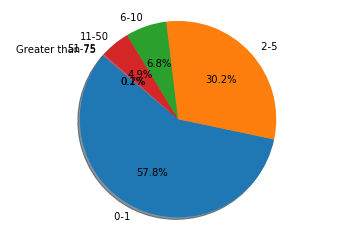

In [9]:
#Plot
plt.pie(pie_chart['plays'], labels=pie_chart['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

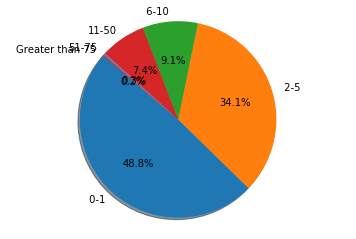

In [10]:
#Apply the category function 
df_artist['category'] = df_artist.apply(f, axis=1)
                                  
art_pc = df_artist.groupby(by=['category'])[['plays']].count().reset_index()
art_pc.head()

plt.pie(art_pc['plays'], labels=art_pc['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

With the song data, over half of the information is based on a song being played a single time.  All data will remain in the analysis; however, the model will be chosen to consider the number of times the song was played.

### GraphLab Canvas

In [11]:
combo_songs.show()

In [12]:
artist.show()

Executing the `graphlab show` commands above will provide summary information about the data in a local browser using GraphLab Canvas.   

The song data includes over 110,000 users listening to over 166,433 unique songs.   The data includes 138,499 unqiue song titles.   The inference is 27,934 songs have the same title although they are different songs.   Analysis will need to be done on the `song_id` rather than the `title`.   Songs were played between 1 times and 923 times.  Both the song data as well as the artist data contain 28,266 unique artists.   Neither dataset has missing values.  The year has some missing values that are populated with 0.  Detail on the missing years can be found in the GraphLab Canvas.   Due to 20% of the year data missing, analysis will not include the year informaiton.  

Since the user identification is based on a user ID, the possiblities of a single person having multiple user IDs or a single user ID being used by multiple individuals cannot be eliminated.   Since the sharing of user IDs is common with families, our analysis will proceed with caution.  

## Train and Adjust parameters

In [13]:
combo_songs.head(3)

Columns:
	user	str
	song_id	str
	plays	int
	title	str
	release	str
	artist_name	str
	year	int
	song_name	str

Rows: 3

Data:
+-------------------------------+--------------------+-------+
|              user             |      song_id       | plays |
+-------------------------------+--------------------+-------+
| fd50c4007b68a3737fe052d5a4... | SOBONKR12A58A7A7E0 |   1   |
| fd50c4007b68a3737fe052d5a4... | SOEGIYH12A6D4FC0E3 |   1   |
| fd50c4007b68a3737fe052d5a4... | SOFLJQZ12A6D4FADA6 |   1   |
+-------------------------------+--------------------+-------+
+-------------------------------+-------------------------------+
|             title             |            release            |
+-------------------------------+-------------------------------+
|         You're The One        |       If There Was A Way      |
| Horn Concerto No. 4 in E f... | Mozart - Eine kleine Nacht... |
|            Tive Sim           |        Nova Bis-Cartola       |
+-------------------------------+-------------------------------+
+-------------------------------+------+--------------------------------+
|          artist_name          | year |           song_name            |
+-------------------------------+------+--------------------------------+
|         Dwight Yoakam         | 1990 | You're The One (Dwight Yoakam) |
| Barry Tuckwell/Academy of ... |  0   | Horn Concerto No. 4 in E f...  |
|            Cartola            | 1974 |       Tive Sim (Cartola)       |
+-------------------------------+------+--------------------------------+
[3 rows x 8 columns]

### Create Cross-Validation Datasets

In [14]:
train_song, test_song = gl.recommender.util.random_split_by_user(combo_songs,
                                                      user_id="user", item_id="song_id",
                                                      item_test_proportion=0.2,
                                                      random_seed=193)

### Song Recommendation
The following is the training and testing of the song usage data.  The analysis includes both the user and the song information.    

A recommender based on the plays from users will be created.  The recommender will suggest 5 songs for each user based on the feedback from other users.

In [15]:
song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 2.73415s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 0us                            | 1.75       |

| 131.504ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 27.022ms                           | 0          |

| 264.863ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 480.101ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.46s                               | 0                | 32              |

| 4.48s                               | 26.25            | 42872           |

| 5.48s                               | 81.25            | 132608          |

| 6.49s                               | 92.75            | 151403          |

| 7.72s                               | 100              | 163100          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.91491s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00338983050847 | 0.00131826741996 |
|   2    | 0.00282485875706 | 0.00267419962335 |
|   3    | 0.00263653483992 | 0.00338041431262 |
|   4    | 0.00225988700565 | 0.00366290018832 |
|   5    | 0.00248587570621 | 0.00469868173258 |
|   6    | 0.00263653483992 | 0.00653483992467 |
|   7    | 0.00306698950767 | 0.00797865662272 |
|   8    | 0.00310734463277 | 0.00901443816698 |
|   9    | 0.00326428123038 | 0.0108505963591  |
|   10   | 0.00316384180791 | 0.0113684871312  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.158193403515799)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+
|

In [16]:
rmse_results['rmse_overall']

7.158193403515799

In [17]:
rmse_results['rmse_by_user'].head(4)

Columns:
	user	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+---------------+
|              user             | count |      rmse     |
+-------------------------------+-------+---------------+
| fbc4d0dcd38c88337a2711afa9... |   3   |      1.0      |
| f20c71c000708dca353d7b80fe... |   6   |      1.0      |
| e750ad77cb54da4309270cd711... |   3   | 17.7951304201 |
| b91ff110a5a622020e266bfddb... |   2   |      1.0      |
+-------------------------------+-------+---------------+
[4 rows x 3 columns]

In [18]:
rmse_results['rmse_by_item'].head(4)

Columns:
	song_id	str
	count	int
	rmse	float

Rows: 4

Data:
+--------------------+-------+---------------+
|      song_id       | count |      rmse     |
+--------------------+-------+---------------+
| SOTTTEQ12B0B80CA01 |   1   |      1.0      |
| SOXPNXR12AB0186600 |   1   | 3.85255803665 |
| SOBSLVH12A8C131F38 |   1   |      1.0      |
| SOJGFVC12A8C13F61A |   1   |      1.0      |
+--------------------+-------+---------------+
[4 rows x 3 columns]

In [19]:
song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = song_rec.evaluate(test_song)

rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 3.00275s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 501us                          | 1.75       |

| 176.776ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 63.545ms                           | 0          |

| 489.359ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 788.229ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.01s                               | 0                | 32              |

| 5.02s                               | 43.5             | 71270           |

| 6.03s                               | 73               | 119066          |

| 8.44s                               | 100              | 163100          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.59831s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.415557720387124)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 914315ec671444238303b4a4bb... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per User

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])

In [20]:
rmse_results['rmse_overall']

6.415557720387124

In [21]:
rmse_results['rmse_by_user'].head(4)

Columns:
	user	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+
| fbc4d0dcd38c88337a2711afa9... |   3   |   3.82224118   |
| f20c71c000708dca353d7b80fe... |   6   |  1.265132998   |
| e750ad77cb54da4309270cd711... |   3   | 15.1101736326  |
| b91ff110a5a622020e266bfddb... |   2   | 0.988502063562 |
+-------------------------------+-------+----------------+
[4 rows x 3 columns]

In [22]:
rmse_results['rmse_by_item'].head(4)

Columns:
	song_id	str
	count	int
	rmse	float

Rows: 4

Data:
+--------------------+-------+---------------+
|      song_id       | count |      rmse     |
+--------------------+-------+---------------+
| SOTTTEQ12B0B80CA01 |   1   | 1.94444444444 |
| SOXPNXR12AB0186600 |   1   |      3.0      |
| SOBSLVH12A8C131F38 |   1   | 2.27960526316 |
| SOJGFVC12A8C13F61A |   1   | 1.80281690141 |
+--------------------+-------+---------------+
[4 rows x 3 columns]

The RMSE (root mean square error) is evaluated for both the cosine and pearson model for the item similarity recommender.  The pearson model is the preferred model with the lower RMSE (6.42 compared to 7.16).

#### Artist Recommendation
Music recommendations may be offered in multiple forms.  In addition to the recommendation of songs, the analysis includes the recommendation of music by artist.  The data was trained as tested the same as the song data to offere comparison of the two collaborative filtering results.   

### Create Cross-Validation Datasets

In [23]:
train_art, test_art = gl.recommender.util.random_split_by_user(artist,
                                                      user_id="user", item_id="artist_name",
                                                      item_test_proportion=0.2,
                                                      random_seed=139)

In [24]:
art_rec = gl.recommender.item_similarity_recommender.create(train_art,
                                                             user_id="user",
                                                             item_id="artist_name",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = art_rec.evaluate(test_art)

rmse_results.viewkeys()

Recsys training: model = item_similarity

Preparing data set.

Data has 1131266 observations with 109997 users and 28356 items.

Data prepared in: 1.68961s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.001ms                        | 3.5        |

| 56.54ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 5.26s                               | 0                | 2               |

| 6.27s                               | 21.5             | 6165            |

| 7.27s                               | 65.25            | 18548           |

| 15.03s                              | 100              | 28356           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 15.4091s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00360576923077 | 0.00190304487179 |
|   2    | 0.00360576923077 | 0.00470753205128 |
|   3    | 0.00400641025641 | 0.00731169871795 |
|   4    | 0.00450721153846 | 0.0102878891941  |
|   5    | 0.00456730769231 | 0.0124914148352  |
|   6    | 0.00460737179487 | 0.0138669490232  |
|   7    | 0.00412087912088 | 0.0141073336386  |
|   8    |    0.00390625    | 0.0157098977411  |
|   9    | 0.00400641025641 | 0.0180536477411  |
|   10   | 0.00396634615385 | 0.0200568528694  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 9.430838813569583)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+
|

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])

In [25]:
rmse_results['rmse_overall']

9.430838813569583

In [26]:
rmse_results['rmse_by_user'].head(4)

Columns:
	user	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+---------------+
|              user             | count |      rmse     |
+-------------------------------+-------+---------------+
| 03588d90ac18e85774d6b7c2ed... |   4   | 3.53553390593 |
| 92c79d7d197ef4c310435f44c7... |   7   | 1.88982236505 |
| 1b2153eee4a57634ce84e3253d... |   3   | 1.67481768027 |
| ce25b00dd1c07541661d824303... |   2   | 5.09901951359 |
+-------------------------------+-------+---------------+
[4 rows x 3 columns]

In [27]:
rmse_results['rmse_by_item'].head(4)

Columns:
	artist_name	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+---------------+
|          artist_name          | count |      rmse     |
+-------------------------------+-------+---------------+
|           The Dells           |   1   |      2.0      |
| Tom Petty And The Heartbre... |   3   | 1.41421356237 |
|            Mr. Big            |   1   |      1.0      |
|          Brad Paisley         |   2   | 1.58113883008 |
+-------------------------------+-------+---------------+
[4 rows x 3 columns]

In [28]:
art_rec = gl.recommender.item_similarity_recommender.create(train_art,
                                                             user_id="user",
                                                             item_id="artist_name",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = art_rec.evaluate(test_art)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Preparing data set.

Data has 1131266 observations with 109997 users and 28356 items.

Data prepared in: 2.03892s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 0us                            | 0.75       |

| 145.787ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.02s                               | 0                | 0               |

| 4.03s                               | 22.25            | 6350            |

| 10.32s                              | 100              | 28356           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 10.6382s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 8.631102496645925)

Per User RMSE (best)
+-------------------------------+-------+-----------------+
|              user             | count |       rmse      |
+-------------------------------+-------+-----------------+
| f6d7c4daa209e6164a2b6eaf6b... |   1   | 0.0634253393367 |
+-------------------------------+---

In [29]:
rmse_results['rmse_overall']

8.631102496645925

In [30]:
rmse_results['rmse_by_user'].head(4)

Columns:
	user	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+---------------+
|              user             | count |      rmse     |
+-------------------------------+-------+---------------+
| 03588d90ac18e85774d6b7c2ed... |   4   | 2.40522045846 |
| 92c79d7d197ef4c310435f44c7... |   7   | 1.64184410056 |
| 1b2153eee4a57634ce84e3253d... |   3   | 3.14899571108 |
| ce25b00dd1c07541661d824303... |   2   | 3.14502019694 |
+-------------------------------+-------+---------------+
[4 rows x 3 columns]

In [31]:
rmse_results['rmse_by_item'].head(4)

Columns:
	artist_name	str
	count	int
	rmse	float

Rows: 4

Data:
+-------------------------------+-------+-----------------+
|          artist_name          | count |       rmse      |
+-------------------------------+-------+-----------------+
|           The Dells           |   1   | 0.0634253393367 |
| Tom Petty And The Heartbre... |   3   |  2.24097285631  |
|            Mr. Big            |   1   |       1.24      |
|          Brad Paisley         |   2   |  2.84499070898  |
+-------------------------------+-------+-----------------+
[4 rows x 3 columns]

The recommendation models were run for the artist prediction to offer a comparison.   Although it may be expected that the recommendation model would be better with the same amount plays data yet fewer recommendations; however, that was incorrect.  Both models for the artist prediction were significantly higher than the song recommendation counterpart.   

The model for song recommendation using the pearsons similarity type will be used for the remainder of the analysis.  

### Ranking Factorization Recommender
The ranking factorication recommender learns factors from the user and item.  This model of prediction is preferred for rankings.  Since the plays data is similar to ranking, the results of this model will be compared with the results of the item similarity recommender.  This model is also know as cross validating collaborative filtering.   The model is very time consuming to process with a large dataset.

The initial model will include the ranking factorization with no latent factors.   The following analysis will include the selection of the ideal number of latent factors.   Finally the ranking factorization model with the ideal latent factors will be compared to the item similarity model.

In [32]:
recl = gl.recommender.ranking_factorization_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays")

rmse_results = recl.evaluate(test_song)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 6.90723s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 186145 / 1489167 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 7.14286           | Not Viable                               |

| 1       | 1.78571           | Not Viable                               |

| 2       | 0.446429          | Not Viable                               |

| 3       | 0.111607          | 42.9718                                  |

| 4       | 0.0558036         | 48.2073                                  |

| 5       | 0.0279018         | 56.6168                                  |

| 6       | 0.0139509         | 62.2928                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.111607          | 42.9718                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 96.5072           | 7.01622               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 8.59s        | 122.45            | 9.56818               | 0.111607    |

| 2       | 15.51s       | 95.5659           | 8.72372               | 0.111607    |

| 3       | 22.51s       | 91.3799           | 8.52535               | 0.111607    |

| 4       | 29.76s       | 91.7268           | 8.54764               | 0.111607    |

| 5       | 37.52s       | 93.3246           | 8.63063               | 0.111607    |

| 6       | 44.64s       | 95.9376           | 8.76024               | 0.111607    |

| 7       | 51.04s       | 99.14             | 8.92293               | 0.111607    |

| 8       | 56.48s       | 102.647           | 9.08838               | 0.111607    |

| 9       | 1m 1s        | 105.771           | 9.25158               | 0.111607    |

| 10      | 1m 8s        | 110.429           | 9.46173               | 0.111607    |

| 11      | 1m 14s       | 113.639           | 9.60626               | 0.111607    |

| 12      | 1m 23s       | DIVERGED          | DIVERGED              | 0.111607    |

| RESET   | 1m 26s       | 96.507            | 7.0162                |             |

| 1       | 1m 34s       | 90.1898           | 8.0132                | 0.0558036   |

| 2       | 1m 41s       | 74.4991           | 7.47231               | 0.0558036   |

| 3       | 1m 48s       | 67.7526           | 7.09986               | 0.0558036   |

| 4       | 1m 55s       | 64.0137           | 6.88842               | 0.0558036   |

| 5       | 2m 1s        | 61.427            | 6.73769               | 0.0558036   |

| 6       | 2m 7s        | 59.5537           | 6.6257                | 0.0558036   |

| 7       | 2m 13s       | 58.038            | 6.53745               | 0.0558036   |

| 8       | 2m 19s       | 56.7548           | 6.46066               | 0.0558036   |

| 9       | 2m 27s       | 55.7184           | 6.39654               | 0.0558036   |

| 10      | 2m 35s       | 54.7553           | 6.33812               | 0.0558036   |

| 11      | 2m 44s       | 53.8351           | 6.2802                | 0.0558036   |

| 12      | 2m 50s       | 53.0946           | 6.23298               | 0.0558036   |

| 13      | 2m 57s       | 52.2908           | 6.18263               | 0.0558036   |

| 14      | 3m 2s        | 51.6697           | 6.14185               | 0.0558036   |

| 15      | 3m 8s        | 51.0162           | 6.10176               | 0.0558036   |

| 16      | 3m 14s       | 50.3645           | 6.05965               | 0.0558036   |

| 17      | 3m 20s       | 49.824            | 6.02199               | 0.0558036   |

| 18      | 3m 26s       | 49.2533           | 5.985                 | 0.0558036   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 46.375

Final training RMSE: 5.77687


Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |  0.00225988700565 | 0.000367231638418 |
|   2    |  0.00112994350282 | 0.000367231638418 |
|   3    |  0.0015065913371  | 0.000969868173258 |
|   4    |  0.00112994350282 | 0.000969868173258 |
|   5    |  0.00090395480226 | 0.000969868173258 |
|   6    |  0.00075329566855 | 0.000969868173258 |
|   7    | 0.000807102502018 |  0.00119585687382 |
|   8    | 0.000988700564972 |  0.00270244821092 |
|   9    |  0.00100439422473 |  0.00298493408663 |
|   10   |  0.00101694915254 |  0.00354990583804 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.241851637543805)

Per User RMSE (best)
+-------------------------------+-------+-----------------+
|              user             | count |       rmse      |
+-----------------------------

In [33]:
rmse_results['rmse_overall']

7.241851637543805

### Determine songs with highest RMSE

In [34]:
item_rmse = rmse_results['rmse_by_item'].sort('rmse', False)

item_rmse = item_rmse.to_dataframe().merge(song_df, how='left', left_on='song_id', right_on='song_id')

item_rmse['song_name'] = item_rmse['title'] + ' (' + item_rmse['artist_name'] +')'

item_rmse[['title', 'artist_name', 'rmse', 'count']].head()

title     artist_name        rmse  \
0  Pocket Of A Clown (2006 Remastered LP Version)   Dwight Yoakam  111.841146   
1                               The Break Up Song  American Hi-Fi  104.099148   
2                            Numb (Album Version)       Disturbed   60.079615   
3      Elevator [Feat. Timbaland] (Album Version)        Flo Rida   54.826629   
4                                          Slowly      Amon Tobin   51.378227   

   count  
0      1  
1      1  
2      2  
3      1  
4      1

### Get Metrics for various cutoffs

In [35]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall')])

Columns:
	cutoff	int
	Avg of precision	float
	Stdv of precision	float
	Avg of recall	float

Rows: 18

Data:
+--------+-------------------+-------------------+-------------------+
| cutoff |  Avg of precision | Stdv of precision |   Avg of recall   |
+--------+-------------------+-------------------+-------------------+
|   36   | 0.000596359070935 |  0.00402615022158 |  0.00840866290019 |
|   2    |  0.00112994350282 |   0.023742261457  | 0.000367231638418 |
|   46   | 0.000614099729796 |  0.00360178784049 |  0.0131638418079  |
|   31   | 0.000656096227447 |  0.00455345277499 |  0.00818267419962 |
|   26   | 0.000608431116906 |  0.00479906328152 |  0.00573446327684 |
|   8    | 0.000988700564972 |  0.0110729418771  |  0.00270244821092 |
|   5    |  0.00090395480226 |  0.0134154323884  | 0.000969868173258 |
|   16   | 0.000847457627119 |  0.00722827208018 |  0.00505649717514 |
|   41   | 0.000578751550227 |  0.00371226859374 |  0.00963276836158 |
|   4    |  0.00112994350282 |  0.0167692904855  | 0.000969868173258 |
+--------+-------------------+-------------------+-------------------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

The cross validation model increased the RMSE from 6.42 to 7.24.  
The aggregate of the precision and recall are evaluated for this model.   Precision is the measurement of not predicting falsely.  Recall is the measurement of correct predictions.  Accuracy is the measure the fraction of prediting correct.  

### Determine correct number of latent factors
Since the RMSE decreased with the cross validation, the model will be slightly adjusted from the default to be analyzed again with the number latent factors clearly designated.  In order to determin the correct number of latent factors, models will be run for 3 different possible latent factors.  

In [36]:
params = {'user_id': 'user',
         'item_id': 'song_id',
         'target': 'plays',
         'num_factors': [4, 6, 8],
         'regularization': [0.001] ,
         'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train_song,test_song),
                                      gl.recommender.ranking_factorization_recommender.create,
                                      params,
                                      max_models=3,
                                      environment=None)

In [39]:
job.get_status()

{'Canceled': 0, 'Completed': 3, 'Failed': 0, 'Pending': 0, 'Running': 0}

In [40]:
job_result = job.get_results()

job_result.head()

Columns:
	model_id	int
	item_id	str
	linear_regularization	float
	max_iterations	int
	num_factors	int
	num_sampled_negative_examples	int
	ranking_regularization	float
	regularization	float
	target	str
	user_id	str
	training_precision@5	float
	training_recall@5	float
	training_rmse	float
	validation_precision@5	float
	validation_recall@5	float
	validation_rmse	float

Rows: 3

Data:
+----------+---------+-----------------------+----------------+-------------+-------------------------------+
| model_id | item_id | linear_regularization | max_iterations | num_factors | num_sampled_negative_examples |
+----------+---------+-----------------------+----------------+-------------+-------------------------------+
|    1     | song_id |         0.001         |       25       |      8      |               8               |
|    0     | song_id |         0.001         |       25       |      4      |               4               |
|    2     | song_id |         0.001         |       25       |      6      |               8               |
+----------+---------+-----------------------+----------------+-------------+-------------------------------+
+------------------------+----------------+--------+---------+----------------------+
| ranking_regularization | regularization | target | user_id | training_precision@5 |
+------------------------+----------------+--------+---------+----------------------+
|          0.25          |     0.001      | plays  |   user  |   0.00494363636364   |
|          0.1           |     0.001      | plays  |   user  |   0.00621272727273   |
|          0.1           |     0.001      | plays  |   user  |       0.00688        |
+------------------------+----------------+--------+---------+----------------------+
+-------------------+---------------+------------------------+---------------------+
| training_recall@5 | training_rmse | validation_precision@5 | validation_recall@5 |
+-------------------+---------------+------------------------+---------------------+
|  0.00176677959681 | 6.72930209702 |          0.0           |         0.0         |
|  0.00241865153234 | 6.47626545108 |   0.000677966101695    |   0.00254237288136  |
|  0.00274440942618 | 6.50387473226 |   0.000677966101695    |   0.00254237288136  |
+-------------------+---------------+------------------------+---------------------+
+-----------------+
| validation_rmse |
+-----------------+
|  7.01691769734  |
|  6.66943630391  |
|  6.62668267111  |
+-----------------+
[3 rows x 16 columns]

In [41]:
bst_prms = job.get_best_params()
bst_prms

{'item_id': 'song_id',
 'linear_regularization': 0.001,
 'max_iterations': 25,
 'num_factors': 6,
 'num_sampled_negative_examples': 8,
 'ranking_regularization': 0.1,
 'regularization': 0.001,
 'target': 'plays',
 'user_id': 'user'}

In [42]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : user
 Item ID                          : song_id
 Target                           : plays
 Additional observation features  : 5
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 1489167
 Number of users                  : 110000
 Number of items                  : 163100
 
 Training summary
 ----------------
 Training time                    : 111.1648
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 4
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 25
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001


In [43]:
comparisonstruct = gl.compare(test_song, models)
gl.show_comparison(comparisonstruct, models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-------------------+------------------+
| cutoff |   mean_precision  |   mean_recall    |
+--------+-------------------+------------------+
|   1    |        0.0        |       0.0        |
|   2    |        0.0        |       0.0        |
|   3    |        0.0        |       0.0        |
|   4    |        0.0        |       0.0        |
|   5    | 0.000677966101695 | 0.00254237288136 |
|   6    | 0.000941619585687 | 0.00348399246704 |
|   7    |  0.00225988700565 | 0.00642498430634 |
|   8    |  0.00254237288136 | 0.0089673571877  |
|   9    |  0.00238543628374 | 0.00934400502197 |
|   10   |  0.00225988700565 | 0.00962649089768 |
+--------+-------------------+------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+-------------------+------------------+
| cutoff |   mean_precision  |   mean_recall    |
+--------+---------

In [44]:
models[1]

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user
Item ID                          : song_id
Target                           : plays
Additional observation features  : 5
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 1489167
Number of users                  : 110000
Number of items                  : 163100

Training summary
----------------
Training time                    : 115.0815

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 8
binary_target                    : 0
side_data_factorization          : 1
solver                           : auto
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.001
regularization_type              :

### Selected latent factors
Comparisons of the three models for latent factors results in the 8 latent factor model being the more precise.   We will run that model and then compare to the item similarity model.

In [46]:
recl = gl.recommender.ranking_factorization_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                              num_factors=8, 
                                                              regularization=1e-02,
                                                              linear_regularization = 1e-3)

rmse_results = recl.evaluate(test_song)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 8.53464s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 186145 / 1489167 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00494779        | 99.3306                                  |

| 1       | 0.0024739         | 100.121                                  |

| 2       | 0.00123695        | 100.681                                  |

| 3       | 0.000618474       | 101.009                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00494779        | 99.3306                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 498us        | 96.5072           | 7.01621               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 4.55s        | 95.9411           | 7.01159               | 0.00494779  |

| 2       | 8.45s        | 95.6714           | 7.00841               | 0.00494779  |

| 3       | 12.77s       | 94.8487           | 7.00244               | 0.00494779  |

| 4       | 18.79s       | 94.3499           | 7.00014               | 0.00494779  |

| 5       | 22.24s       | 94.0066           | 6.99968               | 0.00494779  |

| 6       | 25.82s       | 93.7536           | 6.99983               | 0.00494779  |

| 7       | 29.64s       | 93.5588           | 7.00034               | 0.00494779  |

| 8       | 34.03s       | 93.4027           | 7.00115               | 0.00494779  |

| 9       | 38.33s       | 93.2749           | 7.00207               | 0.00494779  |

| 10      | 42.56s       | 93.1681           | 7.00303               | 0.00494779  |

| 11      | 47.16s       | 93.0773           | 7.00402               | 0.00494779  |

| 12      | 52.76s       | 92.9989           | 7.00501               | 0.00494779  |

| 13      | 57.97s       | 92.93             | 7.00599               | 0.00494779  |

| 14      | 1m 2s        | 92.869            | 7.00705               | 0.00494779  |

| 15      | 1m 6s        | 92.8149           | 7.00799               | 0.00494779  |

| 16      | 1m 11s       | 92.7655           | 7.00895               | 0.00494779  |

| 17      | 1m 15s       | 92.7212           | 7.00992               | 0.00494779  |

| 18      | 1m 21s       | 92.6806           | 7.01083               | 0.00494779  |

| 19      | 1m 26s       | 92.6434           | 7.01174               | 0.00494779  |

| 20      | 1m 32s       | 92.6088           | 7.01263               | 0.00494779  |

| 21      | 1m 39s       | 92.5767           | 7.01351               | 0.00494779  |

| 22      | 1m 45s       | 92.5469           | 7.01438               | 0.00494779  |

| 23      | 1m 51s       | 92.5192           | 7.01516               | 0.00494779  |

| 24      | 1m 57s       | 92.4929           | 7.01601               | 0.00494779  |

| 25      | 2m 1s        | 92.468            | 7.01678               | 0.00494779  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 92.5434

Final training RMSE: 7.01505


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00790960451977 | 0.0031450094162  |
|   2    | 0.0045197740113  | 0.0034274952919  |
|   3    | 0.00376647834275 | 0.00393596986817 |
|   4    | 0.00706214689266 | 0.0128719397363  |
|   5    | 0.00813559322034 | 0.0171522733387  |
|   6    | 0.0075329566855  |  0.018517621738  |
|   7    | 0.00677966101695 | 0.0193650793651  |
|   8    | 0.00649717514124 | 0.0214680297731  |
|   9    | 0.00627746390458 | 0.0244812124473  |
|   10   | 0.00587570621469 | 0.0261761277016  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.367230836593305)

Per User RMSE (best)
+-------------------------------+-------+------------------+
|              user             | count |       rmse       |
+-------------------------------+-------+---------------

In [47]:
rmse_results['rmse_overall']

6.367230836593305

In [48]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall')])

Columns:
	cutoff	int
	Avg of precision	float
	Stdv of precision	float
	Avg of recall	float

Rows: 18

Data:
+--------+------------------+-------------------+-----------------+
| cutoff | Avg of precision | Stdv of precision |  Avg of recall  |
+--------+------------------+-------------------+-----------------+
|   36   | 0.00332705586943 |  0.0103684626363  |  0.048033808627 |
|   2    | 0.0045197740113  |  0.0473229188506  | 0.0034274952919 |
|   46   | 0.00316875460575 |  0.00901515136148 | 0.0578185812932 |
|   31   | 0.00357207946054 |  0.0115342711075  | 0.0452560308493 |
|   26   | 0.00399826162538 |  0.0134630071957  | 0.0428643171016 |
|   8    | 0.00649717514124 |  0.0289923278949  | 0.0214680297731 |
|   5    | 0.00813559322034 |  0.0406365137192  | 0.0171522733387 |
|   16   | 0.00536723163842 |  0.0191947541597  | 0.0367061250112 |
|   41   | 0.00325203252033 |  0.00964058203252 | 0.0535059635907 |
|   4    | 0.00706214689266 |  0.0430918291824  | 0.0128719397363 |
+--------+------------------+-------------------+-----------------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

The ranking factorization has RSME of 6.37 compared to the item similarity RSME of 6.42.   The two models provide similar accuracy results.  

A final comparison of the two models will be done.

In [49]:
#Preferred item similarity method (song & pearson)
song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 2.57579s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.002ms                        | 0.75       |

| 240.191ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 27.02ms                            | 0          |

| 333.901ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 670.683ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.84s                               | 0                | 32              |

| 4.85s                               | 35.25            | 57608           |

| 5.86s                               | 60               | 98194           |

| 6.87s                               | 81.75            | 133432          |

| 9.01s                               | 100              | 163100          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 9.25221s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.415557465660254)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 914315ec671444238303b4a4bb... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per User

In [50]:
comparison = gl.recommender.util.compare_models(test_song, [song_rec, recl])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.415557465660254)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 914315ec671444238303b4a4bb... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 

In [51]:
comparisonstruct = gl.compare(test_song, [song_rec, recl])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00790960451977 | 0.0031450094162  |
|   2    | 0.0045197740113  | 0.003

In [52]:
gl.show_comparison(comparisonstruct,[song_rec, recl])

## Evaluate and Compare

Throughout the modeling process comparisons were made to determine the best model.  The final result is to use the item similarity due to the neglibigle difference in RMSE.   However, the processes is significantly faster providing faster results.   

## Visualize Results

In [53]:
#Run final model (song & pearson)
song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="pearson")

rmse_results = song_rec.evaluate(test_song)

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year, song_name;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489167 observations with 110000 users and 163100 items.

Data prepared in: 2.9857s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.006ms                        | 0.75       |

| 167.159ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 25.517ms                           | 0          |

| 348.245ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 582.453ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.70s                               | 0                | 32              |

| 4.70s                               | 38.75            | 63367           |

| 5.72s                               | 76.25            | 124435          |

| 6.72s                               | 94               | 153628          |

| 8.35s                               | 100              | 163100          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.62986s


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.415557351565876)

Per User RMSE (best)
+-------------------------------+-------+------+
|              user             | count | rmse |
+-------------------------------+-------+------+
| 914315ec671444238303b4a4bb... |   1   | 0.0  |
+-------------------------------+-------+------+
[1 rows x 3 columns]


Per User

In [54]:
item_rmse = rmse_results['rmse_by_item'].sort('rmse', False)

item_rmse = item_rmse.to_dataframe().merge(song_df, how='left', left_on='song_id', right_on='song_id')

item_rmse['song_name'] = item_rmse['title'] + ' (' + item_rmse['artist_name'] +')'

item_rmse[['title', 'artist_name', 'rmse', 'count']].head()

title              artist_name  \
0  Pocket Of A Clown (2006 Remastered LP Version)            Dwight Yoakam   
1                               The Break Up Song           American Hi-Fi   
2                            Numb (Album Version)                Disturbed   
3                                   Better Things  Everything But The Girl   
4                                          Slowly               Amon Tobin   

         rmse  count  
0  106.250000      1  
1   96.500000      1  
2   59.794878      2  
3   51.658537      1  
4   50.214286      1

### Distribution of RMSE (per song and user)

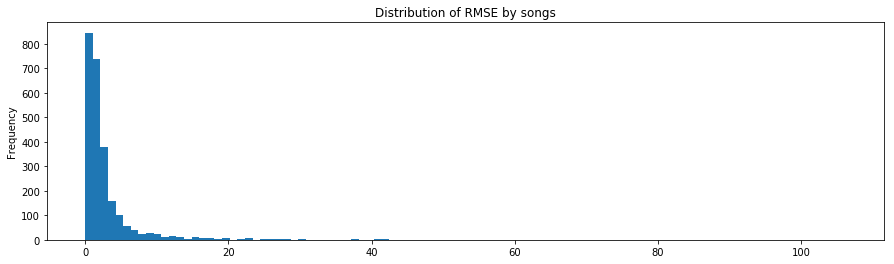

In [55]:
item_rmse_song = item_rmse['rmse']
plt.title('Distribution of RMSE by songs')
item_rmse_song.plot.hist(bins=100, figsize=(15,4))

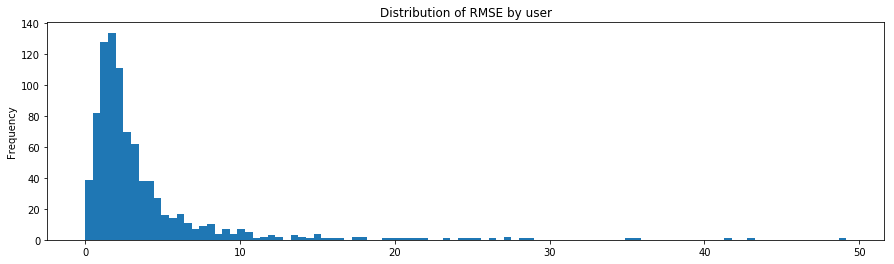

In [56]:
user_rmse = rmse_results['rmse_by_user'].sort('rmse', False).to_dataframe()
plt.title('Distribution of RMSE by user')
user_rmse['rmse'].plot.hist(bins=100, figsize=(15,4))

A few songs have high RMSE.   

A few users have high RMSE.   As mentioned in the early analysis of the data, errors for the prediction of certain users may be related to multiple family members accessing the music using the same user ID.  In additon, the high RMSE may be due to eclectic music plays.

## Summarize the Ramifications

### Most played songs

One question we might ask is whether song is destined to get a high RMSE if they were played many times. The reasoning is that we can reason that the more often a song gets played, the more likely we might recommend the song when we don't know what else to suggest to the user; thus often we might incur a higher rejection rate for these higher-played songs.

To test this hypothesis, let's take the most played songs and also see how they rank in comparison to other songs (by their `RMSE`:

In [57]:
songs_by_plays = combo_songs.groupby('song_name', [agg.SUM('plays')]).sort('Sum of plays', False)

item_rmse['rmse (worst) rank'] = list(range(1, len(item_rmse)+1))

most_popular_songs = songs_by_plays.to_dataframe().merge(item_rmse, how='left', left_on='song_name', right_on='song_name')

most_popular_songs[['song_name', 'Sum of plays', 'rmse (worst) rank']].head(9)

song_name  Sum of plays  \
0                     You're The One (Dwight Yoakam)         35432   
1                                       Undo (Bj�rk)         33179   
2                            Revelry (Kings Of Leon)         24359   
3                           Sehr kosmisch (Harmonia)         19454   
4  Horn Concerto No. 4 in E flat K495: II. Romanc...         17115   
5  Dog Days Are Over (Radio Edit) (Florence + The...         14279   
6                              Secrets (OneRepublic)         12392   
7                       Ain't Misbehavin (Sam Cooke)         11610   
8                       Use Somebody (Kings Of Leon)         10926   

   rmse (worst) rank  
0              286.0  
1              181.0  
2              327.0  
3              387.0  
4               85.0  
5              213.0  
6              728.0  
7              352.0  
8             1609.0

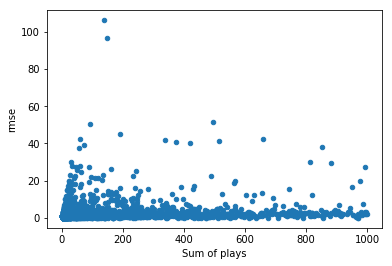

In [58]:
most_popular_songs[most_popular_songs['Sum of plays'] < 1000].plot.scatter(x='Sum of plays', y='rmse')

In [59]:
correlation = most_popular_songs[['Sum of plays', 'rmse']].corr()['rmse']['Sum of plays']
print('Correlation between "Sum of plays" and "RMSE" is {}'.format(correlation))

Correlation between "Sum of plays" and "RMSE" is 0.0609025059445


With a Pearson's R score of just ~ `0.0609`, we are seeing a very weak, positive correlation between how many times a song is played and its RMSE. Thus, it is unlikely to think that higher-played songs generally get a higher RMSE.

### Chosen Model

We decided to use the item-item recommendation system due to its simplicity and predictable nature when deploying. Additionally, it appears that the Pearson's coefficient is the best metric to use to compare distance (as a parameter to the `item_similarity_recommender` function.

## Deployment

Turi has in depth documentation on how to deploy a GraphLab model. Specifically, there seems to be three ways to make a deployment:

 - Turi Distributed
 - Turi Predictive Services
 - Simply running `predict` against your chosen model
 
 
[Turi Distributed](https://turi.com/learn/userguide/deployment/pipeline-introduction.html) provides a way to distribute to ec2 or hadoop clusters. Turi Distributed also adds some management tools to help with your production environment.

[Turi Predictive Services](https://turi.com/learn/userguide/deployment/pred-intro.html) offers another service to deploy your models. This way may be considered to be more robust as much of the deployment process and management is completely automated.

If the production environment would be on a local environment, you could just load your model locally and run predictions as needed.


## Exceptional Work

We were really excited to see this project in action. We tried all three different ways to deploy our model. The first two "automated" ways to deploy threw errors when we got to the final steps due to some S3 error.

We attempted to create our own small environment. The working example can be visited [here](http://ec2-52-53-178-233.us-west-1.compute.amazonaws.com:3000/) and below:

In [60]:
from IPython.display import IFrame
IFrame('http://ec2-52-53-178-233.us-west-1.compute.amazonaws.com:3000/', width=700, height=220)

As you can see, if you select a song title, another song will be recommended based on your choice. This project includes having a python script that polls for a `song_id` as its stdin, which then returns a list of recommendations. A nodejs server sits above the python script to provide a fast, lightweight web server to serve the recommendations. The full source code for this project can be found [here](https://github.com/kjprice/graph-lab-demo).

## References

Reference for the dataset:

    @INPROCEEDINGS{Bertin-Mahieux2011,
      author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
      title = {The Million Song Dataset},
      booktitle = {{Proceedings of the 12th International Conference on Music Information
      Retrieval ({ISMIR} 2011)}},
      year = {2011},
      owner = {thierry},
      timestamp = {2010.03.07}
  